In [2]:
%load_ext autoreload
%autoreload 2   

In [9]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub, TUDataset
from torch_geometric.utils import to_networkx, scatter, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from icecream import ic

In [11]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [12]:
from torch_geometric.datasets import KarateClub


## Pytorch geometric introduction

![](../resources/image.png)

In [13]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(
    x=x, edge_index=edge_index.t().contiguous(), y=torch.tensor([[1], [2], [3]])
)

print("Data")
for key, item in data:
    print(f"{key}:{item}")

data.to(device)

Data
x:tensor([[-1.],
        [ 0.],
        [ 1.]])
edge_index:tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])
y:tensor([[1],
        [2],
        [3]])


Data(x=[3, 1], edge_index=[4, 2], y=[3, 1])

In [14]:
ic(data.x)
ic(data.num_edges, data.num_nodes)
ic(data.has_self_loops())
ic(data.is_directed())

ic| data.x: tensor([[-1.],
                    [ 0.],
                    [ 1.]], device='mps:0')
ic| data.num_edges: 2, data.num_nodes: 3
ic| data.has_self_loops(): False
ic| data.is_directed(): False


False

In [15]:
tu_ds = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")  # , use_node_attr=True)
tu_ds
ic("Nb of graphs in the dataset", len(tu_ds))

ic(tu_ds.y);


ic| 'Nb of graphs in the dataset', len(tu_ds): 600
| 'Nb of graphs in the dataset', len(tu_ds): 600
ic| tu_ds.y: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
tu_ds

ENZYMES(600)

In [17]:
ic(
    tu_ds.num_node_attributes,
    tu_ds.num_node_features,
    tu_ds.num_classes,
    tu_ds.num_edge_features,
)
ic(
    "One graph", tu_ds[0]
)  # Contains 37 nodes, each one with 3 features. There are 168/2=84 undirected edges. the graph is assigned to 1 class (y)
# One can shuffle the dataset
tu_ds.shuffle()

ic| tu_ds.num_node_attributes: 18
    tu_ds.num_node_features: 3
    tu_ds.num_classes: 6
    tu_ds.num_edge_features: 0
ic| 'One graph', tu_ds[0]: Data(edge_index=[2, 168], x=[37, 3], y=[1])


ENZYMES(600)

In [22]:
adj_matrix = to_dense_adj(tu_ds[0].edge_index, max_num_nodes=tu_ds[0].num_nodes)
ic(adj_matrix.shape, adj_matrix);

ic| adj_matrix.shape: torch.Size([1, 37, 37])
    adj_matrix: tensor([[[0., 1., 1.,  .| adj_matrix.shape: torch.Size([1, 37, 37])
    adj_matrix: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
                         [1., 0., 1.,  ..., 0., 0., 0.],
                         [1., 1., 0.,  ..., 0., 0., 0.],
                         ...,
                         [0., 0., 0.,  ..., 0., 1., 1.],
                         [0., 0., 0.,  ..., 1., 0., 0.],
                         [0., 0., 0.,  ..., 1., 0., 0.]]])


# Batche

Adjacency matrix is defined by edge_index.

\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}\end{split}

We take batches size of graphs. 32 means we take batches of 32 graphs. Each graph as a y (a type)

In [ ]:
loader = DataLoader(tu_ds, batch_size=32, shuffle=True)
for batch in loader:
    ic(batch)
    ic(
        batch.batch.shape,
        "the batch vector contains the index of the graph to which each node belongs",
        batch.batch.unique(),
        "contains up to 32 (batch_size) unique values",
    )
    ic(batch.x.shape)
    ic(batch.num_graphs)
    ic(batch.y.shape)
    

    break


ic| batch: DataBatch(edge_index=[2, 3708], x=[979, 3], y=[32], batch=[979], ptr=[33])
ic| batch.batch.shape: torch.Size([979])
    "the batch vector contains the index of the graph to which each node belongs": 'the batch vector contains the index of the graph to which each node belongs'
    batch.batch.unique(): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                                  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
    "contains up to 32 (batch_size) unique values": 'contains up to 32 (batch_size) unique values'
ic| batch.x.shape: torch.Size([979, 3])
ic| batch.num_graphs: 32
ic| batch.y.shape: torch.Size([32])


In [23]:
def plot_graph(G, figsize=(10, 7), node_color="lightblue", edge_color="gray"):
    plt.figure(figsize=figsize)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=node_color,
        edge_color=edge_color,
        cmap="Set2",
    )


/Users/jkunz/Projects/cop_gnn/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


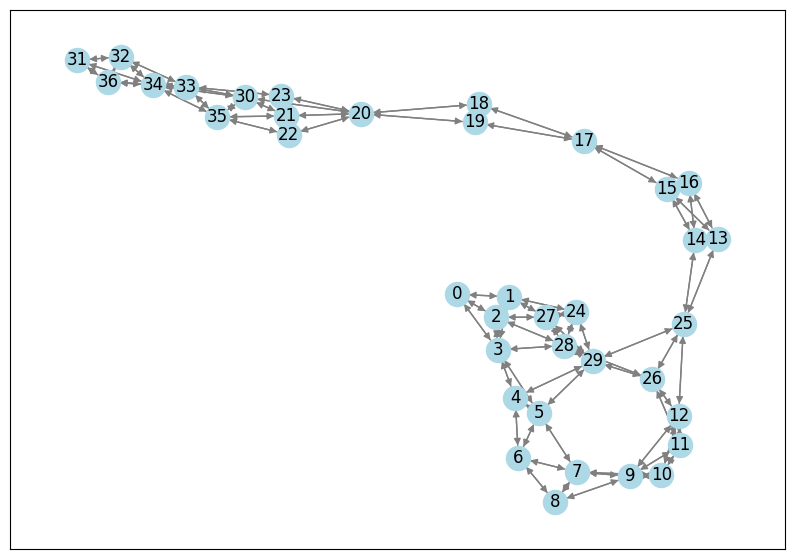

In [24]:
# we show the first graph in the dataset
tuG = to_networkx(tu_ds[0])
plot_graph(tuG)


## Node2vec

https://pytorch-geometric.readthedocs.io/en/latest/tutorial/shallow_node_embeddings.html

https://spotintelligence.com/2024/01/18/node2vec/


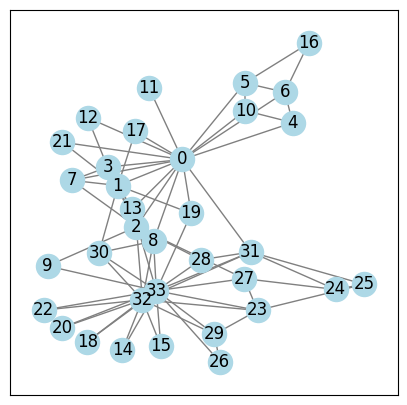

In [12]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]


G = to_networkx(data, to_undirected=True)

plot_graph(G, figsize=(5, 5))

In [13]:
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list
labels = data.y.numpy()  # Community labels (0 or 1)

# Construct adjacency matrix (without self-loops for neighborhood computation)
A = torch.zeros((num_nodes, num_nodes))
A[edge_index[0], edge_index[1]] = 1  # Undirected graph

edge_index[0], edge_index[1]
# matrix is symmetric
A[0,] == A[:, 0]


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

In [14]:
i = 0
j = 1
neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
neighbors_i
A[0].nonzero(as_tuple=True)[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [15]:
# Compute Jaccard similarity matrix
def compute_jaccard_similarity(A):
    S = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):  # Symmetric matrix, compute upper triangle
            neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
            neighbors_j = set(A[j].nonzero(as_tuple=True)[0].tolist())
            intersection = len(neighbors_i & neighbors_j)
            union = len(neighbors_i | neighbors_j)
            if union > 0:  # Avoid division by zero
                sim = intersection / union
                S[i, j] = sim
                S[j, i] = sim  # Symmetry
    # No self-loops in Jaccard (typically similarity to self is not 1 unless defined)
    return S


S = compute_jaccard_similarity(A)
print("Jaccard similarity matrix sample:\n", S)  # S[:5, :5])


Jaccard similarity matrix sample:
 tensor([[1.0000, 0.3889, 0.2381,  ..., 0.0000, 0.1200, 0.1379],
        [0.3889, 1.0000, 0.2667,  ..., 0.0714, 0.1053, 0.1304],
        [0.2381, 0.2667, 1.0000,  ..., 0.2308, 0.0476, 0.2857],
        ...,
        [0.0000, 0.0714, 0.2308,  ..., 1.0000, 0.0588, 0.0952],
        [0.1200, 0.1053, 0.0476,  ..., 0.0588, 1.0000, 0.5263],
        [0.1379, 0.1304, 0.2857,  ..., 0.0952, 0.5263, 1.0000]])


In [16]:
# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16
node_ids = torch.arange(num_nodes)
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameter for L2 regularization
lambda_reg = 0.01  # Regularization strength


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    recon_loss = torch.norm(S_hat - S, p="fro") ** 2

    # L2 regularization: lambda * ||Z||^2
    l2_reg = lambda_reg * torch.norm(Z, p="fro") ** 2

    loss = recon_loss + l2_reg

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(800):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 34684.9805
Epoch 100, Loss: 3035.4995
Epoch 200, Loss: 875.8530
Epoch 300, Loss: 367.2539
Epoch 400, Loss: 185.6792
Epoch 500, Loss: 106.0940
Epoch 600, Loss: 66.5244
Epoch 700, Loss: 44.8910
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[-0.0562,  0.4519,  0.1405,  0.0572, -0.0774,  0.0228, -0.2660, -0.1322,
          0.2367,  0.1090, -0.1186,  0.0388, -0.2673,  0.1185, -0.0389, -0.3236],
        [-0.0387, -0.0032,  0.1852,  0.0360, -0.0778,  0.0962, -0.0748,  0.1177,
          0.0394,  0.0158, -0.7692,  0.2385, -0.6380,  0.1040, -0.0175, -0.0788],
        [-1.0529, -0.0286,  0.4454, -0.0115, -0.0394,  0.1510,  0.0728, -0.2482,
          0.0091,  0.0485, -0.0858, -0.1705,  0.0143, -0.0623,  0.0064, -0.4275],
        [ 0.0745, -0.0970,  0.1466,  0.0925, -0.3847,  0.1046,  0.0467,  0.0531,
          0.2190,  0.1704, -0.1760, -0.1234, -0.1423,  0.0217, -0.0493, -0.4136],
        [-0.0853, -0.2365, -0.5613,  0.5521,  0.2702,  0.2313, -0.2955,  0.0

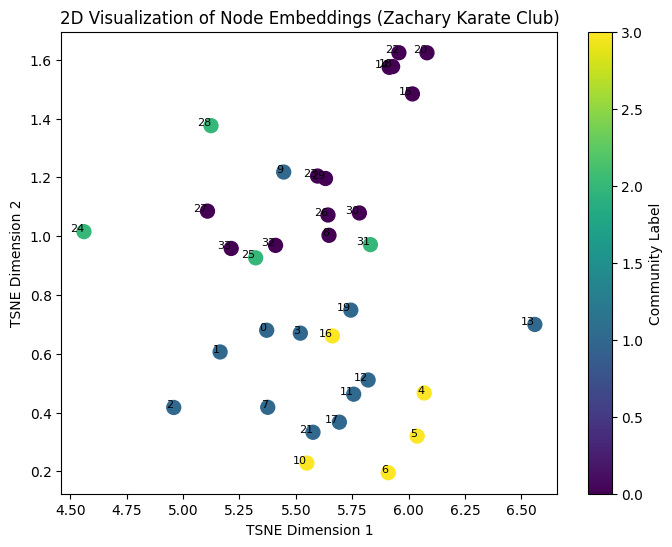

In [17]:
# Reduce embeddings to 2D using TSNE
Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

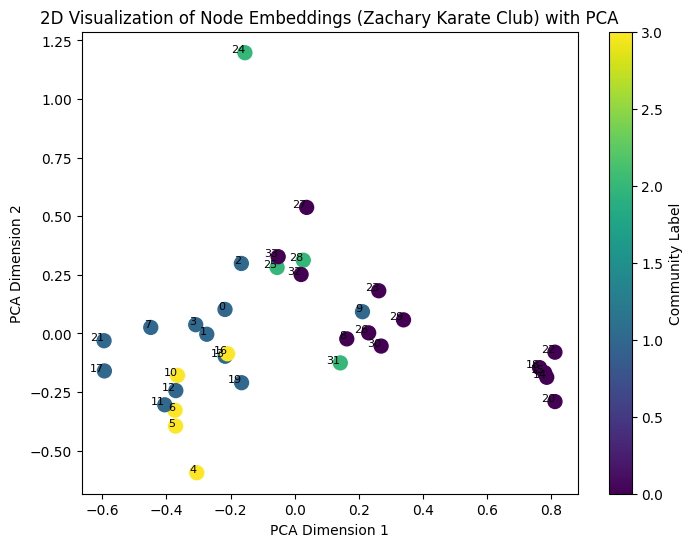

In [18]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club) with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

In [20]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Single graph
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list

# Construct the similarity matrix S (adjacency matrix)
S = torch.zeros((num_nodes, num_nodes))
S[edge_index[0], edge_index[1]] = 1  # Undirected graph
S = S + torch.eye(num_nodes)  # Add self-loops (optional)


# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        # Embedding layer: each node gets a unique embedding
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        # Lookup embeddings for all nodes
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16  # Embedding dimension
node_ids = torch.arange(num_nodes)  # Node indices [0, 1, ..., 33]
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    loss = torch.norm(S_hat - S, p="fro") ** 2

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])  # First 5 nodes

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 25542.6484
Epoch 20, Loss: 13015.8496
Epoch 40, Loss: 7297.1040
Epoch 60, Loss: 4544.0107
Epoch 80, Loss: 3065.2268
Epoch 100, Loss: 2188.3733
Epoch 120, Loss: 1628.2966
Epoch 140, Loss: 1250.5627
Epoch 160, Loss: 985.1307
Epoch 180, Loss: 792.4874
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[ 1.3361e-02, -2.5695e-01, -1.1896e-01, -7.1069e-01, -2.5601e-01,
         -1.1986e-01,  8.3988e-01, -3.4550e-01, -8.6112e-02, -3.5650e-01,
         -2.5094e-01, -4.3274e-02, -3.4174e-02, -1.3173e+00,  4.3330e-01,
          1.3022e-01],
        [ 6.1620e-02,  8.1166e-02, -4.9693e-01, -9.9517e-01, -2.9540e-01,
         -2.5267e-01,  1.7872e-01,  5.2258e-02,  2.4485e-01,  3.1953e-01,
          1.0416e-01,  1.3272e-01, -8.3969e-02, -4.2011e-01,  4.6108e-02,
          1.1217e-04],
        [-4.0010e-01, -1.3155e-01, -3.4146e-01, -3.6725e-01,  1.3727e-01,
         -1.3545e-01,  1.2572e-01,  1.3980e+00,  7.0261e-01,  2.8591e-02,
          6.7172e-02,  4.5817e-01